In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [2]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [3]:
import keras
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [4]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [5]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\Anish mankani\AppData\Local\Temp\ipykernel_13284\2347655966.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');           # sns means seaborn


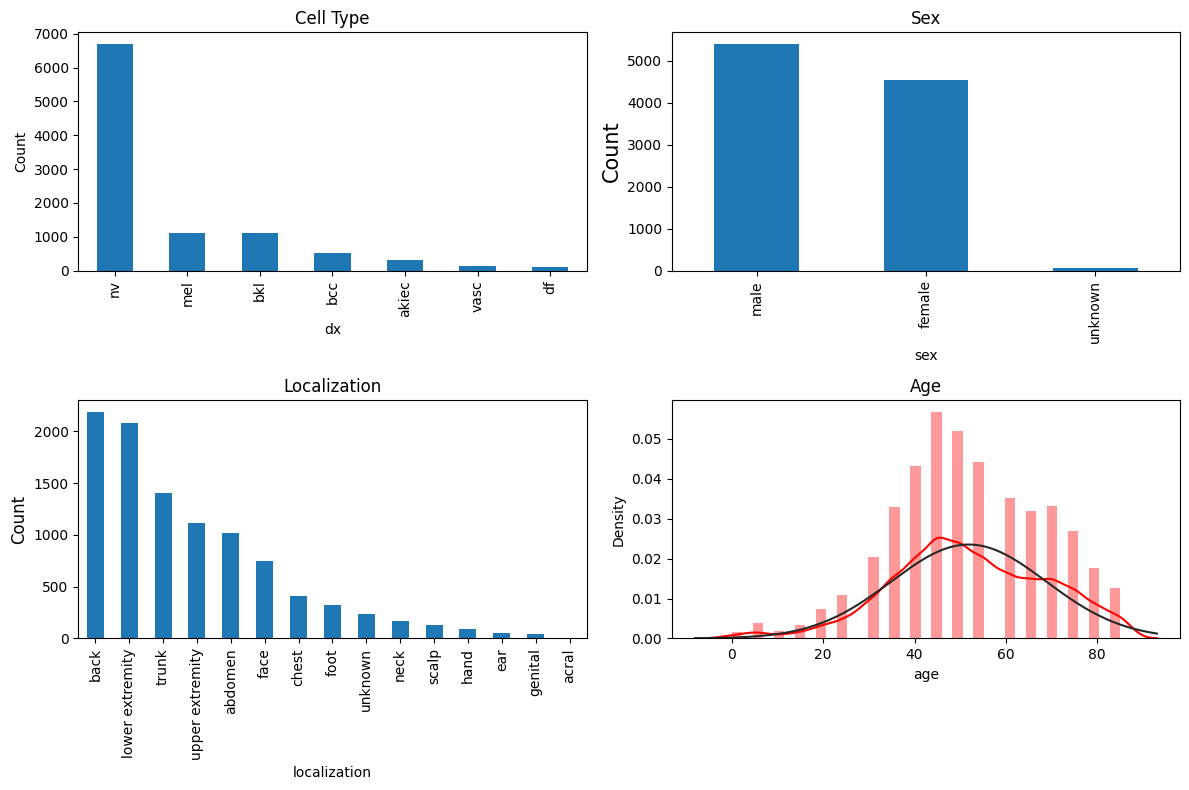

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1) # 7 disease ke name hai
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)  # male and female
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]   # jo null nahi hai woh sample age mein aagayi
sns.distplot(sample_age['age'], fit=stats.norm, color='red');           # sns means seaborn
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [8]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())     # yaha hum find kar rahe hai kaunsi disease ke kitne case hai

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


AS YOU CAN SEE DATA IS HIGHLY UNSTABLE WE HAVE TO MAKE IT STABLE 

In [9]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

ISMEIN HUM RESAMPLE KAR RAHE TAKI SABKE EQUALLY DATA DISTRIBUTE HO

In [10]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [11]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [12]:
skin_df_balanced       #YEH NEW DATAFRAME HAI

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


In [13]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [14]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}  # os path join combine multiple path into single


# input -'data/subdir1/image1.jpg'
# Example Output: 'image1.jpg'  base name nikal hai  os path base name ne
 # split jpg
  # Example Input: 'image1.jpg'
 # Example Output: 'image1'

#'data/' is the base directory.
 #'*' is a wildcard that matches any directory or subdirectory inside data/.
 #'*.jpg' matches any file with the .jpg extension in those subdirectories.

#glob()
 #Purpose: Finds all files that match the pattern provided as an argument.

In [15]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced.head()# jo image jis id ka hai uska path find karega

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data\HAM10000_images_part_1\ISIC_0026645.jpg
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data\HAM10000_images_part_1\ISIC_0025780.jpg
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0024450.jpg
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data\HAM10000_images_part_1\ISIC_0027896.jpg
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0029268.jpg


In [16]:
SIZE=32
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
skin_df_balanced.head()          # image ko resize karna hai 32 * 32    np.asarray() converts the resized image into a NumPy array.

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data\HAM10000_images_part_1\ISIC_0026645.jpg,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data\HAM10000_images_part_1\ISIC_0025780.jpg,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0024450.jpg,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data\HAM10000_images_part_1\ISIC_0027896.jpg,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0029268.jpg,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."


In [17]:
skin_df_balanced.to_csv('file1.csv')

In [18]:
skin_df_balanced['image']

9789    [[[155, 118, 107], [162, 126, 118], [174, 140,...
9957    [[[138, 76, 82], [131, 64, 68], [139, 73, 81],...
9793    [[[123, 86, 87], [174, 137, 137], [197, 161, 1...
9758    [[[205, 149, 175], [207, 149, 169], [214, 158,...
9875    [[[203, 174, 199], [205, 174, 197], [206, 175,...
                              ...                        
2375    [[[15, 12, 12], [40, 30, 32], [87, 67, 71], [1...
2436    [[[148, 109, 118], [121, 93, 102], [112, 87, 9...
2453    [[[248, 181, 199], [248, 183, 201], [248, 186,...
2377    [[[180, 133, 143], [189, 147, 158], [192, 150,...
2363    [[[192, 174, 169], [197, 179, 175], [200, 179,...
Name: image, Length: 3500, dtype: object

In [19]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X


array([[[[155, 118, 107],
         [162, 126, 118],
         [174, 140, 138],
         ...,
         [159, 118, 103],
         [161, 128, 120],
         [136, 110, 104]],

        [[147, 107,  93],
         [156, 117, 105],
         [170, 133, 128],
         ...,
         [172, 133, 121],
         [176, 143, 133],
         [172, 145, 139]],

        [[165, 131, 123],
         [156, 115, 100],
         [156, 113, 103],
         ...,
         [172, 133, 117],
         [167, 130, 113],
         [161, 129, 123]],

        ...,

        [[144, 108,  90],
         [150, 115,  95],
         [155, 119,  99],
         ...,
         [182, 148, 137],
         [182, 149, 137],
         [184, 155, 147]],

        [[144, 109,  88],
         [149, 114,  95],
         [153, 116,  96],
         ...,
         [181, 145, 133],
         [186, 155, 145],
         [182, 155, 149]],

        [[141, 105,  86],
         [144, 107,  88],
         [150, 113,  93],
         ...,
         [179, 146, 133],
        

In [20]:
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
X.shape

(3500, 32, 32, 3)

In [21]:
print(skin_df_balanced['label'])  # label disease ke name ka transform jo kiya woh hai 1 se 7 tak

9789    0
9957    0
9793    0
9758    0
9875    0
       ..
2375    6
2436    6
2453    6
2377    6
2363    6
Name: label, Length: 3500, dtype: int32


In [22]:
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
Y_cat.shape                             # 0 0 0 0 0 0 1

(3500, 7)

# Train Test Split

In [23]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

# Keras Model

In [24]:
#Define the model.
#I've used autokeras to find out the best model for this problem.


num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))  # relu remove negative value keep positive one
#model.add(BatchNormalization())          convolutiona layer is a   detective layer      # conv2d  edges, textures,
model.add(MaxPool2D(pool_size=(2, 2)))  #If the detective found something important in a small area, max pooling keeps just the most important part and discards the rest.
model.add(Dropout(0.3))  # focus on learning the general features of a cat, like:The shape of the ears.The whiskers.The eyes.

model.add(Conv2D(128, (3, 3),activation='relu'))  ##Conv2D is like a magnifying glass for finding features.
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  #Simplifying the Image  #MaxPooling2D is like shrinking the picture to focus on what matters.
model.add(Dropout(0.3))  ##Dropout helps the robot avoid memorizing too much.

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())  # 15 * 15 *64 =14400  make 3d into 1d  #Flatten is like taking notes.

model.add(Dense(32))               ##Dense is the robot’s final decision-making process.
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# 7,168 means the robot has learned 7,168 different ways to look for features.

# 0  is there because the robot isn't learning anything new here; it’s just simplifying the picture.
#  0 is there because no learning happens here.

#384,455 is how many things the robot has learned in total.



C:\Users\Anish mankani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#"None" here means it can handle any batch size (this number is flexible during training).

#15, 15: These represent the height and width of the image
#256: This is the number of channels  it means colour  red green blue

#The Conv2D layer detects 256 different features in the image, so the shape becomes (128, 128, 256).
#The Dense layer has 32 neurons

In [26]:
# Train


batch_size = 16 
epochs = 10

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),  #Validation data is used to evaluate the model’s performance on unseen data during training.
  #x_test: Test images.
  #y_test: Test labels.
    verbose=2)  # verbose means 2: Shows a summary of each epoch (useful for logging).

Epoch 1/10
165/165 - 20s - 121ms/step - acc: 0.1608 - loss: 1.9435 - val_acc: 0.2297 - val_loss: 1.8710
Epoch 2/10
165/165 - 15s - 88ms/step - acc: 0.2674 - loss: 1.7395 - val_acc: 0.3326 - val_loss: 1.5782
Epoch 3/10
165/165 - 14s - 87ms/step - acc: 0.3524 - loss: 1.5744 - val_acc: 0.3931 - val_loss: 1.5352
Epoch 4/10
165/165 - 14s - 83ms/step - acc: 0.3962 - loss: 1.4953 - val_acc: 0.3589 - val_loss: 1.5196
Epoch 5/10
165/165 - 14s - 85ms/step - acc: 0.4389 - loss: 1.4195 - val_acc: 0.4423 - val_loss: 1.3732
Epoch 6/10
165/165 - 14s - 83ms/step - acc: 0.4613 - loss: 1.3561 - val_acc: 0.4731 - val_loss: 1.3377
Epoch 7/10
165/165 - 15s - 91ms/step - acc: 0.4629 - loss: 1.3839 - val_acc: 0.4263 - val_loss: 1.3648
Epoch 8/10
165/165 - 16s - 98ms/step - acc: 0.4808 - loss: 1.3000 - val_acc: 0.4800 - val_loss: 1.3164
Epoch 9/10
165/165 - 14s - 83ms/step - acc: 0.4907 - loss: 1.2684 - val_acc: 0.5051 - val_loss: 1.2361
Epoch 10/10
165/165 - 15s - 93ms/step - acc: 0.5021 - loss: 1.2546 - val

In [27]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.5261 - loss: 1.2262
Test accuracy: 0.5199999809265137


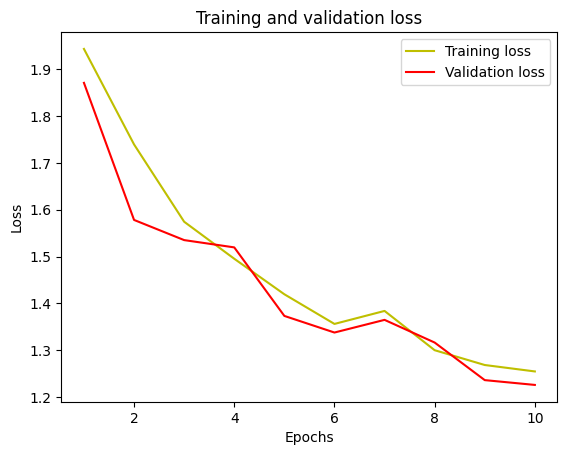

In [28]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Training loss should always decrease.
 #Validation loss should decrease steadily and eventually stabilize.
 #If validation loss increases while training loss decreases, the model may be overfitting.

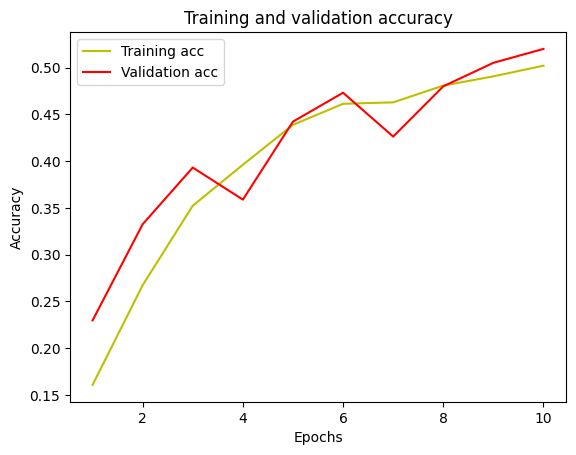

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#raining Accuracy: Line steadily rises and stabilizes near 1.0 (100%).
#Validation Accuracy: Line follows a similar trend but may stabilize slightly lower than the training accuracy.

In [30]:

import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk

In [31]:
def upload_diagnose_file():
    global img
    global filename
    global val
    f_types = [('Jpg Files', '*.jpg')]
    l3.config(text="Disease")
    
    filename = filedialog.askopenfilename(filetypes=f_types)  # function to open a filename  ex image1
    img=Image.open(filename)#      yaha image1 open hoga
    
    img_resized=img.resize((400,200)) # new width & height  resizing hogi
    
    img=ImageTk.PhotoImage(img_resized)
    
    b2 =tk.Button(my_w,image=img) # using Button A button (b2) is created to show the image at the specified position in the interface.
    #b2.grid(row=3,column=1)
    b2.place(x=450,y=320)

    
    f = filename.split("/")        #filename = "/images/dataset/photos/image_12345.png"Output: ['images', 'dataset', 'photos', 'image_12345.png']

    f2=f[-1]                        #"image_12345.png"
    fl = f2.split(".")              #'image_12345', 'png'
    fnl = fl[0]                     # "image_12345"
    
    val2="abc"                                #check karega file database mein hai ki nahi
    for ind in skin_df.index:
        if str(skin_df['image_id'][ind]) == fnl:
            val2=str(skin_df['dx'][ind])
    
    pth=filename
    #pth = 'data\HAM10000_images_part_1\ISIC_0025195.jpg'
    # initialize list elements 
    data = [pth] 

    
    
    
    # Create the pandas DataFrame with column name is provided explicitly 
    df = pd.DataFrame(data, columns=['Path']) 
  
    # print dataframe. 

    filename
    df['image'] = df['Path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
    #Convert dataframe column of images into numpy array
    target_X = np.asarray(df['image'].tolist())
    target_X = target_X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.

    # Prediction on test data
    #y_pred = model.predict(x_test)
    y_pred = model.predict(target_X)
    y_pred

    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_pred_classes
    df_new = skin_df_balanced[skin_df_balanced['label'] == y_pred_classes[0]]
    valv=df_new['dx'].iloc[0]
    
    if val2==valv:   # valv is prediction
        val=valv
    else:
        val=val2
    

In [32]:
import mysql.connector

In [33]:
def dname():
    mydb = mysql.connector.connect(host="localhost",user="root",password="",database="disease")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT disease FROM symptoms where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    for x in myresult:
        l3.config(text="Disease : " + str(x))

In [34]:
def symptoms():
    msg="Following are Symptoms \n"
    mydb = mysql.connector.connect(host="localhost",user="root",password="",database="disease")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT symptoms FROM symptoms where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    i=1
    for x in myresult:
        msg = msg + str(i) + ":" + str(x) + "\n"
        i=i+1
    
    l4.config(text=msg)

In [35]:
def treatment():
    msg="Following are Treatments \n"
    mydb = mysql.connector.connect(host="localhost",user="root",password="",database="disease")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT treatment FROM treatment where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    i=1
    for x in myresult:
        msg = msg + str(i) + ":" + str(x) + "\n"
        i=i+1
    
    l5.config(text=msg)

# Final GUI

In [ ]:
my_w = tk.Tk()         #tk ka object banaya
my_w.configure(background='lavender')
my_w.geometry("900x750")  # Size of the window 
my_w.title('Skin Desease Diagnosis')
my_font1=('times', 14, 'bold')
my_font2=('times', 10, 'bold')

l1 = tk.Label(my_w,text='Add Skin Disease Photo',width=30,font=my_font1)  
#l1.grid(row=1,column=1)
l1.place(x=200,y=15)

b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_diagnose_file())
b1.place(x=20,y=50)

b2 = tk.Button(my_w, text='Diagnose', 
   width=20,command = dname)
b2.place(x=200,y=50)

b3 = tk.Button(my_w, text='Symptoms', 
   width=20,command = symptoms)
b3.place(x=400,y=50)

b4 = tk.Button(my_w, text='Treatment', 
   width=20,command = treatment)
b4.place(x=600,y=50)


l3 = tk.Label(my_w,text='Disease',width=30,font=my_font1)  
#l3.grid(row=5,column=1)
l3.place(x=20,y=100)

l4 = tk.Label(my_w,text='Symptoms',width=200,font=my_font2)  
#l3.grid(row=5,column=1)
l4.place(x=-300,y=150)

l5 = tk.Label(my_w,text='Treatment',width=100,font=my_font2)  
#l3.grid(row=5,column=1)
l5.place(x=100,y=550)

#b1.grid(row=2,column=1)
#b2.grid(row=2,column=2)

my_w.mainloop()  # Keep the window open





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
